# more various prompt

## ○○_instructions.jsonの作成

In [1]:
import os
base_folder = "/data/dataset/yyama_dataset/tasks/VI_ICL/various_30"  # jsonファイルを保存するベースフォルダのパス
os.makedirs(base_folder, exist_ok=True)

In [8]:
import os
import json
# コンテキストのフォルダを先に実行すること

def natural_sort_key(s):
    """
    ファイル名の数字部分を考慮してソートするためのキー関数
    """
    import re
    return [int(text) if text.isdigit() else text.lower() for text in re.split('(\d+)', s)]

def generate_json_from_directory(directory_path, output_json_path): # コンテキスト用
    output = {"data": {}}
    i = 0
    # メインディレクトリ内のサブディレクトリを走査
    for main_folder in os.listdir(directory_path):
        main_folder_path = os.path.join(directory_path, main_folder)
        
        # サブディレクトリがディレクトリであるかの確認
        if os.path.isdir(main_folder_path):
            
            # サブディレクトリ内のサブディレクトリを走査
            for sub_folder in os.listdir(main_folder_path):
                sub_folder_path = os.path.join(main_folder_path, sub_folder)
                
                # サブディレクトリ内のファイルを昇順に走査
                for image_file in sorted(os.listdir(sub_folder_path), key=natural_sort_key):
                    # 画像ファイルの拡張子を除去
                    image_name_without_extension = os.path.splitext(image_file)[0]
                    
                    # キーの名前を生成
                    key_name = f"{main_folder}+{sub_folder}+{image_name_without_extension}"
                    
                    # JSONのデータ構造を生成
                    output["data"][key_name] = {
                        "instruction": "",
                        "answer": "",
                        "flag": "context",
                        "image_ids": [key_name],
                        "rel_ok_ins_ids": [],
                        "rel_ng_ins_ids": [],
                        "label": i
                    }
                i += 1
    
    # JSONをファイルに書き出し
    with open(output_json_path, "w", encoding="utf-8") as json_file:
        json.dump(output, json_file, indent=4, ensure_ascii=False)



In [ ]:
# プログラムの実行
output_json_path = f"{base_folder}/train_instructions.json"
context_path = "/data/dataset/yyama_dataset/VI_images/VI_full_train_context"
generate_json_from_directory(context_path, output_json_path)

output_json_path = f"{base_folder}//val_instructions.json"
context_path = "/data/dataset/yyama_dataset/VI_images/VI_full_val_context"
generate_json_from_directory(context_path, output_json_path)

In [9]:
import os
import json
import random
# コンテキストのフォルダを実行した後に実行すること

def natural_sort_key(s):
    """
    ファイル名の数字部分を考慮してソートするためのキー関数
    """
    import re
    return [int(text) if text.isdigit() else text.lower() for text in re.split('(\d+)', s)]

def generate_and_merge_json_from_directory(directory_path, old_json_path, NUM): #クエリ用
    # 以前のJSONを読み込む
    with open(old_json_path, "r", encoding="utf-8") as f:
        old_data = json.load(f)

    new_data = {"data": {}}
    i = 0
    # メインディレクトリ内のサブディレクトリを走査
    for main_folder in os.listdir(directory_path):
        main_folder_path = os.path.join(directory_path, main_folder)

        # サブディレクトリがディレクトリであるかの確認
        if os.path.isdir(main_folder_path):

            # サブディレクトリ内のサブディレクトリを走査
            for sub_folder in os.listdir(main_folder_path):
                sub_folder_path = os.path.join(main_folder_path, sub_folder)

                # サブディレクトリ内のファイルを昇順に走査
                for image_file in sorted(os.listdir(sub_folder_path), key=natural_sort_key):
                    # 画像ファイルの拡張子を除去
                    image_name_without_extension = os.path.splitext(image_file)[0]

                    # キーの名前を生成
                    key_name = f"{main_folder}+{sub_folder}+{image_name_without_extension}"

                    # rel_ok_ins_idsの値を取得
                    """以下どちらか選択"""
                    related_ok_keys = [key for key in old_data["data"].keys() if key.startswith(f"{main_folder}+None")] # "欠陥"の場合
                    # related_ok_keys = [key for key in old_data["data"].keys() if key.startswith(f"{main_folder}+{main_folder}+")] # "製品+欠陥"の場合
                    rel_ok_ins_ids = random.sample(related_ok_keys, min(NUM, len(related_ok_keys)))

                    # rel_ng_ins_idsの値を取得
                    """以下どちらか選択"""
                    if sub_folder == "None": # "欠陥"の場合
                    # if main_folder==sub_folder: # "製品+欠陥"の場合
                        """以下どちらか選択"""
                        related_ng_keys = [key for key in old_data["data"].keys() if key.startswith(f"{main_folder}+") and not key.startswith(f"{main_folder}+None")] # "欠陥"の場合
                        # related_ng_keys = [key for key in old_data["data"].keys() if key.startswith(f"{main_folder}+") and not key.startswith(f"{main_folder}+{main_folder}+")] # "製品+欠陥"の場合
                        related_ng_key_lists = {}
                        for key in related_ng_keys:
                            prefix = key.split('+')[1]
                            if prefix not in related_ng_key_lists:
                                related_ng_key_lists[prefix] = []
                            related_ng_key_lists[prefix].append(key)

                        rel_ng_ins_ids = []
                        while len(rel_ng_ins_ids) < NUM and related_ng_key_lists:
                            for prefix in list(related_ng_key_lists.keys()):
                                if related_ng_key_lists[prefix]:
                                    selected_key = random.choice(related_ng_key_lists[prefix])
                                    rel_ng_ins_ids.append(selected_key)
                                    related_ng_key_lists[prefix].remove(selected_key)
                                else:
                                    del related_ng_key_lists[prefix]
                    else: # 不良品の場合
                        related_ng_keys = [key for key in old_data["data"].keys() if key.startswith(f"{main_folder}+{sub_folder}+")]
                        rel_ng_ins_ids = random.sample(related_ng_keys, min(NUM, len(related_ng_keys)))

                    # JSONのデータ構造を生成
                    new_data["data"][key_name] = {
                        "instruction": "",
                        "answer": "",
                        "flag": "query",
                        "image_ids": [key_name],
                        "rel_ok_ins_ids": rel_ok_ins_ids,
                        "rel_ng_ins_ids": rel_ng_ins_ids,
                        "label": i
                    }
                i += 1

    # 既存のJSONデータに新しいデータをマージ
    old_data["data"].update(new_data["data"])

    # JSONをファイルに書き出し
    # old_json_path = "output.json"
    with open(old_json_path, "w", encoding="utf-8") as json_file:
        json.dump(old_data, json_file, indent=4, ensure_ascii=False)


In [ ]:
# 数の確認
def count_data(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)["data"]
        
    entries = [item for item in data.values() if item["flag"] == "context"]
    count = len(entries)
    print(f"context: {count}")
        
    entries = [item for item in data.values() if item["flag"] == "query"]
    count = len(entries)
    print(f"query: {count}")

In [ ]:
# プログラムの実行
output_json_path = f"{base_folder}/train_instructions.json"
query_path = f"/data/dataset/yyama_dataset/VI_images/VI_full_train_query"
NUM = 5 # 良品、不良品をそれぞれ5枚ずつ選ぶ
generate_and_merge_json_from_directory(query_path, output_json_path, NUM)

output_json_path = f"{base_folder}/val_instructions.json"
query_path = f"/data/dataset/yyama_dataset/VI_images/VI_full_val_query"
NUM = 5 # 良品、不良品をそれぞれ5枚ずつ選ぶ
generate_and_merge_json_from_directory(query_path, output_json_path, NUM)

print("train")
json_path = f"{base_folder}/train_instructions.json"
count_data(json_path)

print("val")
json_path = f"{base_folder}/val_instructions.json"
count_data(json_path)

### instructionとanswerを埋める

In [2]:
question_lines = [
    ["In the image provided, can you identify any apparent defects such as {defect} on this {product}?"],
    ["Regarding the image, does this {product} exhibit any noticeable issues, for example, {defect}?"],
    ["Looking at the image, are there discernible problems like {defect} present on the {product}?"],
    ["Upon examining the image, are defects such as {defect} visible on this {product}?"],
    ["Can any {defect}-type anomalies be spotted on the {product} in the image?"],
    ["In this image, do you see any faults, specifically like {defect}, on the {product}?"],
    ["Are imperfections, particularly {defect}, observable on the {product} in the image?"],
    ["Does the image reveal any {defect} or similar flaws on the {product}?"],
    ["Upon inspecting the image, are there any {defect} defects noticeable on the {product}?"],
    ["Can one notice any {defect}-like issues in the {product} as depicted in the image?"],
    ["Is there any evidence of {defect} or related faults on the {product} in the image?"],
    ["Does this {product}, as shown in the image, have any visible anomalies, particularly {defect}?"],
    ["Can you point out any visible {defect} faults in the {product} in the provided image?"],
    ["Are there signs of {defect} or similar problems on the {product} shown in the image?"],
    ["Regarding the image of the {product}, are there any noticeable {defect}-type faults?"],
    ["In the image, do you detect any faults such as {defect} on this {product}?"],
    ["Does the {product} in the image exhibit any {defect} or comparable defects?"],
    ["Looking at this {product} in the image, are faults like {defect} visible?"],
    ["Can any faults, particularly of the {defect} variety, be seen on the {product} in the image?"],
    ["In the image shown, are there any detectable {defect}-like flaws on the {product}?"],
    ["Is there any evidence of structural weaknesses or visible damages such as {defect} in the {product}, as can be clearly seen in the attached image?"],
    ["Could you please confirm if there are any noticeable issues like {defect} on this particular {product}, as depicted in the provided image?"],
    ["In the image of the {product}, are there any visible signs of wear or damage, specifically anything resembling {defect}?"],
    ["Based on the image provided, does the {product} exhibit any physical defects or anomalies, particularly anything akin to {defect}?"],
    ["Can you detect any apparent flaws or imperfections, such as {defect}, on the {product} as it appears in the image?"],
    ["Upon examining the image, would you say that the {product} shows any signs of faults or deterioration, especially anything similar to {defect}?"],
    ["Does the {product}, as seen in the image, display any defects or damages that could be classified as {defect}?"],
    ["Are there any visible indicators of poor craftsmanship or defects, like {defect}, on the {product} as showcased in the image?"],
    ["In the provided image, does this {product} show any signs of failing quality or specific defects such as {defect}?"],
    ["Upon close inspection of the image, are there any noticeable defects or quality issues in the {product}, particularly something that resembles {defect}?"],
]

yes_responses_array = [
    ["Yes. The {product} definitely shows {defect}."],
    ["Yes. A clear indication of {defect} on this {product} suggests it's defective."],
    ["Yes. Signs of {defect} are evident in the {product}, indicating a problem."],
    ["Yes. This {product} has {defect}, a clear defect."],
    ["Yes. Unmistakably, the {product} shows {defect}, pointing to a defect."],
    ["Yes. {defect} in the {product} is obvious, indicating a significant defect."],
    ["Yes. Considering the {product}, the presence of {defect} suggests it's not in perfect condition."],
    ["Yes. {defect} is noticeable on the {product}, indicating it's not as it should be."],
    ["Yes. With {defect} present, this {product} certainly seems defective."],
    ["Yes. {defect} on this {product} clearly points to a problem."],
    ["Yes. Upon a thorough examination of the {product}, it is quite apparent that there are significant signs of {defect}. This observation is critical as it strongly suggests that the product has a manufacturing or usage defect, which could potentially impact its functionality or aesthetic appeal."],
    ["Yes. After carefully analyzing the {product}, it's clear that there are unmistakable indications of {defect}. This is a cause for concern as it not only affects the integrity of the product but also raises questions about its longevity and reliability in the long term."],
    ["Yes. The presence of {defect} on this particular {product} is undeniable. This kind of flaw is not just superficial but could potentially signify deeper issues within the product, affecting its overall performance and customer satisfaction."],
    ["Yes. The {product} in question undeniably shows signs of {defect}. This finding is significant because it not only diminishes the product's aesthetic value but also suggests a compromise in the quality control processes of its manufacturing."],
    ["Yes. After an in-depth review, it's evident that the {product} exhibits {defect}. This is particularly concerning as it may indicate a lapse in the manufacturing standards or possibly mishandling during shipping or storage."],
    ["Yes. The {product} clearly displays {defect}, which is a red flag for potential buyers. Such defects are not just minor issues but could lead to further complications, possibly affecting the product's usability and customer satisfaction."],
    ["Yes. There is a noticeable presence of {defect} on the {product}, which is alarming. This type of defect could have various implications, ranging from aesthetic damage to potential functional impairments, depending on the severity and nature of the flaw."],
    ["Yes. This {product} unmistakably shows signs of {defect}, which is a significant concern. Defects of this nature are often indicative of deeper problems and could hint at a broader issue with the product line or brand quality."],
    ["Yes. After a detailed inspection, the {product} has visible {defect}, and this cannot be overlooked. Such defects raise serious questions about the product's durability and the reliability of the manufacturer's quality assurance processes."],
    ["Yes. It's unmistakably clear that the {product} has {defect}. This finding is critical as it not only impacts the immediate usability of the product but also raises concerns about its long-term durability and the trustworthiness of the brand."],
    ["Yes. The image clearly shows the {product} exhibiting signs of {defect}, which is a definitive indication of a manufacturing defect or damage during handling."],
    ["Yes. Upon inspecting the image, it's evident that the {product} has visible wear, notably in the form of {defect}, which indicates a decline in its overall condition and quality."],
    ["Yes. The image reveals that the {product} has apparent flaws, specifically {defect}, which raises concerns about its integrity and long-term usability."],
    ["Yes. In the image, the {product} clearly displays defects or damages that align with {defect}, pointing towards quality issues or potential mishandling."],
    ["Yes. The provided image shows the {product} exhibiting signs of failing quality, particularly defects akin to {defect}, which is a cause for concern regarding its overall reliability."],
    ["Yes. The detailed analysis of the image reveals that the {product} indeed exhibits {defect}. This is not just a superficial issue but a significant concern that could impact the product's functionality and longevity, demanding immediate attention and potential rectification measures."],
    ["Yes. It's unmistakably apparent from the image that the {product} suffers from a {defect}, which is a clear indication of either a manufacturing flaw or damage incurred during transportation. Such defects not only compromise the aesthetic appeal of the product but also raise questions about its overall structural integrity."],
    ["Yes. Upon close examination of the image, the presence of {defect} on the {product} is quite evident. This not only detracts from the product's visual appeal but also indicates potential underlying issues that could affect its performance and durability."],
    ["Yes. The {product}, as depicted in the image, unmistakably shows signs of {defect}. This flaw is not to be taken lightly as it could significantly impair the product's usability and consumer satisfaction, necessitating a thorough investigation into its cause."],
    ["Yes. The analysis of the image indicates that the {product} is afflicted with {defect}. This sort of defect is particularly troubling as it not only affects the immediate functionality of the product but also casts doubt on its reliability and the manufacturer's reputation."],
]

no_responses_array = [
    ["No. This {product} seems fine."],
    ["No. No visible faults like {defect} on the {product}."],
    ["No. {product} appears free of issues such as {defect}."],
    ["No. No {defect} faults detected on the {product}."],
    ["No. After checking, the {product} seems clear of {defect} issues."],
    ["No. {product} lacks any visible {defect} faults, indicating good condition."],
    ["No. Nothing like {defect} found on this {product}."],
    ["No. {product} looks good, no {defect} defects seen."],
    ["No. {product} appears non-defective, lacking {defect} type faults."],
    ["No. This {product} displays no {defect} issues, suggesting it's in prime condition."],
    ["No. After a comprehensive examination of the {product}, it appears to be free of any visible faults like {defect}. This observation is significant as it speaks volumes about the product's quality and the rigorous standards employed in its manufacturing process, ensuring that it is in a non-defective, pristine condition."],
    ["No. The {product} does not show any signs of faults such as {defect}. This is a testament to the high-quality materials and craftsmanship that have gone into its creation, ensuring that the product not only meets but exceeds the expectations of durability and aesthetic appeal."],
    ["No. Upon detailed scrutiny, there are no indications of faults like {defect} on the {product}. This finding is important as it suggests that the product has been manufactured with precision and care, maintaining a high standard of quality control."],
    ["No. The {product} seems to be in impeccable condition, displaying no visible faults like {defect}. This is reassuring as it indicates that the product has been handled and stored with utmost care, preserving its quality and integrity."],
    ["No. After a thorough inspection, the {product} does not exhibit any faults such as {defect}. This is a clear indicator of the product's superior quality and the meticulous attention to detail that has gone into its manufacturing process."],
    ["No. There are no visible signs of any faults like {defect} on the {product}, suggesting it has been crafted to perfection. This lack of defects is a strong indication of the product's robustness and the stringent quality checks it has undergone."],
    ["No. The {product} is devoid of any visible faults, including those like {defect}. This is a significant point, as it not only demonstrates the product's aesthetic perfection but also its functional reliability, which is a crucial aspect for consumer satisfaction."],
    ["No. Upon careful observation, the {product} displays no faults of the {defect} kind. This suggests that the product has passed through rigorous quality assessments, ensuring that it is in top-notch condition for the end-user."],
    ["No. The {product} is in a non-defective state, showing no signs of faults such as {defect}. This lack of defects is commendable and reflects the high standards of quality and care taken in the product's design and manufacturing process."],
    ["No. There are no discernible faults like {defect} on the {product}, which is a clear indicator of its exceptional quality. This flawless condition underscores the manufacturer's commitment to delivering a product that is not only visually appealing but also structurally sound and reliable."],
    ["No. The {product} in the image appears to be free of any significant faults like {defect}, suggesting that it is in an excellent, non-defective condition."],
    ["No. The careful observation of the image confirms that the {product} remains in a faultless state, showing no traces of {defect} or similar defects. This lack of flaws is commendable and suggests that the product has been produced and handled with the utmost care, ensuring it meets the highest standards of quality."],
    ["No. After a comprehensive evaluation of the image, it is evident that the {product} is in excellent condition, free from any defects such as {defect}. This finding underlines the product's robust build quality and the stringent quality assurance processes it has undergone."],
    ["No. The detailed scrutiny of the image reveals that the {product} is in a remarkably non-defective condition, showing no signs of faults like {defect}. This is indicative of a well-made product, reflecting the high-quality materials and skilled workmanship that have gone into its creation."],
    ["No. The thorough inspection of the image suggests that the {product} is devoid of any visible faults, especially those resembling {defect}. This outcome highlights the meticulous attention to detail and the high standards of craftsmanship that went into the making of this product, ensuring its pristine condition."],
    ["No. After meticulously examining the image, it becomes clear that the {product} does not display any faults like {defect}. This absence of defects is a testament to the exceptional quality control measures adopted during its production, ensuring that the product is in an impeccable and non-defective state."],
    ["No. Upon close inspection of the image, the {product} appears devoid of any noticeable defects or quality issues, especially those resembling {defect}, ensuring its superior quality and craftsmanship."],
    ["No. There are no visible indicators of poor craftsmanship or defects like {defect} on the {product} in the image, which speaks to its high-quality construction and finish."],
    ["No. The {product}, as observed in the image, shows no signs of faults or deterioration that could be compared to {defect}, signifying it remains in a pristine state."],
    ["No. After a thorough review of the image, the {product} does not display any physical defects or anomalies resembling {defect}, indicating it is in prime condition."],
]

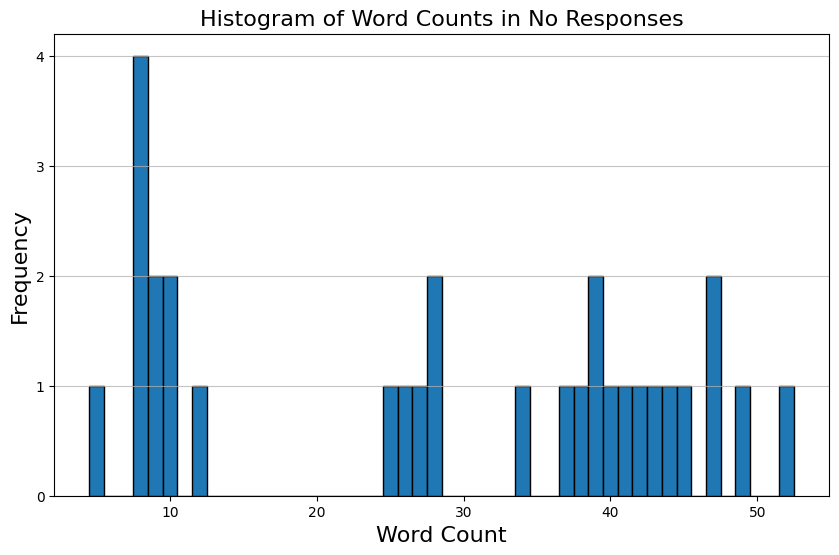

In [7]:
import matplotlib.pyplot as plt
def count_words(sentence):
    return len(sentence.split())
no_word_counts = [count_words(response[0]) for response in no_responses_array]

# ヒストグラムの作成
plt.figure(figsize=(10, 6))
plt.hist(no_word_counts, bins=range(min(no_word_counts), max(no_word_counts) + 2), align='left', edgecolor='black')
plt.title('Histogram of Word Counts in No Responses', fontsize=16)
plt.xlabel('Word Count', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.grid(axis='y', alpha=0.75)
plt.yticks(range(0, 5, 1))

# ヒストグラムの表示
plt.show()

In [7]:
import json
import os
import numpy as np

# 指定されたリスト形式の文字列を作成する関数
def generate_list_string(items):
    # アンダースコアをスペースに変換
    items = [item.replace('_', ' ') for item in items]
    
    if len(items) == 1:
        return items[0]
    elif len(items) == 2:
        return f"{items[0]} and {items[1]}"
    else:
        return ", ".join(items[:-1]) + f", and {items[-1]}"

def fill_instruction_and_answer(json_path, train_context_dir):
    # JSONを読み込む
    random_list = np.zeros(len(question_lines))
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)["data"]

    # ['data']からキーを順に読み込む
    for key, value in data.items():
        # キーの名前から親フォルダ名と子フォルダ名を認識する
        parent_folder, child_folder, _ = key.split("+")

        # "./1_train_context/親フォルダ名"にアクセスし、その中にある子フォルダ名をリスト化する
        subfolder_list = os.listdir(os.path.join(train_context_dir, parent_folder))
        subfolder_list = [folder for folder in subfolder_list if folder != "None"] # 欠陥名のみリスト化

        # "instruction"にテキストを入力する
        parent_folder__ = parent_folder.replace('_', ' ')
        # long
        random_idx = random.randint(0, len(question_lines)-1)
        random_list[random_idx] += 1
        instructions = []
        for q in question_lines:
            instructions.append(q[0].format(product=parent_folder, defect=', '.join(subfolder_list)))
        value["instruction"] = instructions
        
        # "answer"にテキストを入力する
        if child_folder == "None": # "欠陥"の場合
        # if child_folder == parent_folder: # "製品+欠陥"の場合
            answers = []
            for no in no_responses_array:
                answers.append(no[0].format(product=parent_folder, defect=child_folder))
            value["answer"] = answers
        else:
            child_folder = child_folder.replace('_', ' ')
            answers = []
            for yes in yes_responses_array:
                answers.append(yes[0].format(product=parent_folder, defect=child_folder))
            value["answer"] = answers

    # JSONをファイルに書き出し
    with open(json_path, "w", encoding="utf-8") as json_file:
        json.dump({"data": data}, json_file, indent=4, ensure_ascii=False)

# プログラムの実行
output_json_path = f"{base_folder}/train_instructions.json"
train_context_dir = f"/data/dataset/yyama_dataset/VI_images/VI_full_train_context" # コンテキストのみでok (クエリと同じフォルダ構成のため)
fill_instruction_and_answer(output_json_path, train_context_dir)

output_json_path = f"{base_folder}/val_instructions.json"
train_context_dir = f"/data/dataset/yyama_dataset/VI_images/VI_full_val_context" # コンテキストのみでok (クエリと同じフォルダ構成のため)
fill_instruction_and_answer(output_json_path, train_context_dir)

## ○○_train.jsonの作成

In [25]:
import json
import random

def create_visual_inspection_train(input_json_path, output_json_path, NUM_PAIRS):
    # JSONを読み込む
    with open(input_json_path, "r", encoding="utf-8") as f:
        data = json.load(f)["data"]

    train_data = {}

    # ['data']からキーを順に読み込む
    for key, value in data.items():
        # 'flag'=='query'のキーを選択
        if value["flag"] == "query":
            # "rel_ok_ins_ids"と"rel_ng_ins_ids"を読み込み
            ok_ids = value["rel_ok_ins_ids"]
            ng_ids = value["rel_ng_ins_ids"]

            # すべての組み合わせをリストに保存
            combinations = []
            for ok_id in ok_ids:
                for ng_id in ng_ids:
                    combinations.append([ok_id, ng_id])

            # リスト内の各組内の要素をランダムにシャッフル
            for combination in combinations:
                random.shuffle(combination)

            # キー名を更新してデータを保存
            random.shuffle(combinations)
            for i, combination in enumerate(combinations[:NUM_PAIRS]):
                train_data[f"{key}={i}"] = combination

    # JSONをファイルに書き出し
    with open(output_json_path, "w", encoding="utf-8") as json_file:
        json.dump(train_data, json_file, indent=4, ensure_ascii=False)


In [ ]:
NUM_PAIRS = 25 # 1つのクエリに対して生成する組み合わせの数
input_json_path = f"{base_folder}/train_instructions.json"
output_json_path = f"{base_folder}/train_pairs{NUM_PAIRS}_train.json"
create_visual_inspection_train(input_json_path, output_json_path, NUM_PAIRS)

NUM_PAIRS__ = 1 # 1つのクエリに対して生成する組み合わせの数（valは1にするとクエリが一回のみ）
input_json_path = f"{base_folder}/val_instructions.json"
output_json_path = f"{base_folder}/val_pairs{NUM_PAIRS__}_train.json"
create_visual_inspection_train(input_json_path, output_json_path, NUM_PAIRS__)

In [9]:
# 数の確認
def count_data(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
        
    count = len(data.keys())
    print(f"ペア数: {count}")
    oks = [key for key in data.keys() if key.split("+")[1] == "None"] # "欠陥"の場合
    # oks = [key for key in data.keys() if key.split("+")[0] == key.split("+")[1]] # "製品+欠陥"の場合
    print(f"クエリ良品: {len(oks)}")
    ngs = [key for key in data.keys() if key.split("+")[1] != "None"] # "欠陥"の場合
    # ngs = [key for key in data.keys() if key.split("+")[0] != key.split("+")[1]] # "製品+欠陥"の場合
    print(f"クエリ不良品: {len(ngs)}")

In [ ]:
print("train")
# NUM_PAIRS = 25
json_path = f"{base_folder}/train_pairs{NUM_PAIRS}_train.json"
count_data(json_path)
print("val")
# NUM_PAIRS__ = 1
json_path = f"{base_folder}/val_pairs{NUM_PAIRS__}_train.json"
count_data(json_path)

## ○○.jsonの作成（共通）

In [10]:
import json
import os
from PIL import Image
import io
import base64

# コンテキスト　→　クエリの順で実行すること

def image_to_urlsafe_base64_png(img_path):
    """画像をメモリ上でPNGに変換し、その後URL-safeなBase64に変換する関数"""
    with Image.open(img_path) as image:
        # CMYKモードの画像をRGBモードに変換
        if image.mode == 'CMYK':
            image = image.convert('RGB')
        # パレットモードの画像をRGBAモードに変換
        if image.mode == 'P':
            image = image.convert('RGBA')
        buffered = io.BytesIO()
        image.save(buffered, format="PNG")
        img_str = base64.urlsafe_b64encode(buffered.getvalue()).decode('utf-8')
    return img_str

def create_visual_inspection(input_json_path, base_folder, output_json_path):
    # JSONを読み込む
    with open(input_json_path, "r", encoding="utf-8") as f:
        data = json.load(f)["data"]

    # 既存のvisual_inspection.jsonが存在する場合、その内容を読み込む
    if os.path.exists(output_json_path):
        with open(output_json_path, "r", encoding="utf-8") as f:
            visual_data = json.load(f)
    else:
        visual_data = {}

    extensions = ['.png', '.jpg', '.jpeg', '.JPG']

    # ['data']からキーを順に読み込む
    for key in data.keys():
        parent_folder, child_folder, image_name = key.split("+")
        
        # 各拡張子を試して、存在するファイルを見つける
        for ext in extensions:
            img_path = os.path.join(base_folder, parent_folder, child_folder, image_name + ext)
            if os.path.exists(img_path):
                # 画像をURL-safeなBase64 PNG形式に変換
                visual_data[key] = image_to_urlsafe_base64_png(img_path)
                break

    # JSONをファイルに書き出し
    with open(output_json_path, "w", encoding="utf-8") as json_file:
        json.dump(visual_data, json_file, indent=4, ensure_ascii=False)


In [ ]:
import json

# 数の確認
def count_data(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
        
    count = len(data.keys())
    print(f"画像枚数: {count}")

In [ ]:
""" train """
input_json_path = f"{base_folder}/train_instructions.json"
output_json_path = f"{base_folder}/train_images.json"
context_folder = f"/data/dataset/yyama_dataset/VI_images/VI_full_train_context"  # 画像読み込み用
create_visual_inspection(input_json_path, context_folder, output_json_path)
query_folder = f"/data/dataset/yyama_dataset/VI_images/VI_full_train_query"  # 画像読み込み用
create_visual_inspection(input_json_path, query_folder, output_json_path)

""" val """
input_json_path = f"{base_folder}/val_instructions.json"
output_json_path = f"{base_folder}/val_images.json"
context_folder = f"/data/dataset/yyama_dataset/VI_images/VI_full_val_context"  # 画像読み込み用
create_visual_inspection(input_json_path, context_folder, output_json_path)
query_folder = f"/data/dataset/yyama_dataset/VI_images/VI_full_val_query"  # 画像読み込み用
create_visual_inspection(input_json_path, query_folder, output_json_path)

print("train")
json_path = f"{base_folder}/train_images.json"
count_data(json_path)

print("val")
json_path = f"{base_folder}/val_images.json"
count_data(json_path)

# various fix pair

In [1]:
import os
base_folder = "/data/dataset/yyama_dataset/tasks/VI_ICL/various_20fix_rand"  # jsonファイルを保存するベースフォルダのパス
os.makedirs(base_folder, exist_ok=True)

In [2]:
import os
import json
# コンテキストのフォルダを先に実行すること

def natural_sort_key(s):
    """
    ファイル名の数字部分を考慮してソートするためのキー関数
    """
    import re
    return [int(text) if text.isdigit() else text.lower() for text in re.split('(\d+)', s)]

def generate_json_from_directory(directory_path, output_json_path): # コンテキスト用
    output = {"data": {}}
    i = 0
    # メインディレクトリ内のサブディレクトリを走査
    for main_folder in os.listdir(directory_path):
        main_folder_path = os.path.join(directory_path, main_folder)
        
        # サブディレクトリがディレクトリであるかの確認
        if os.path.isdir(main_folder_path):
            
            # サブディレクトリ内のサブディレクトリを走査
            for sub_folder in os.listdir(main_folder_path):
                sub_folder_path = os.path.join(main_folder_path, sub_folder)
                
                # サブディレクトリ内のファイルを昇順に走査
                for image_file in sorted(os.listdir(sub_folder_path), key=natural_sort_key):
                    # 画像ファイルの拡張子を除去
                    image_name_without_extension = os.path.splitext(image_file)[0]
                    
                    # キーの名前を生成
                    key_name = f"{main_folder}+{sub_folder}+{image_name_without_extension}"
                    
                    # JSONのデータ構造を生成
                    output["data"][key_name] = {
                        "instruction": "",
                        "answer": "",
                        "flag": "context",
                        "image_ids": [key_name],
                        "rel_ok_ins_ids": [],
                        "rel_ng_ins_ids": [],
                        "label": i
                    }
                i += 1
    
    # JSONをファイルに書き出し
    with open(output_json_path, "w", encoding="utf-8") as json_file:
        json.dump(output, json_file, indent=4, ensure_ascii=False)



In [3]:
# プログラムの実行
output_json_path = f"{base_folder}/train_instructions.json"
context_path = "/data/dataset/yyama_dataset/VI_images/VI_full_train_context"
generate_json_from_directory(context_path, output_json_path)

output_json_path = f"{base_folder}//val_instructions.json"
context_path = "/data/dataset/yyama_dataset/VI_images/VI_full_val_context"
generate_json_from_directory(context_path, output_json_path)

In [4]:
import os
import json
import random
# コンテキストのフォルダを実行した後に実行すること

def natural_sort_key(s):
    """
    ファイル名の数字部分を考慮してソートするためのキー関数
    """
    import re
    return [int(text) if text.isdigit() else text.lower() for text in re.split('(\d+)', s)]

def generate_and_merge_json_from_directory(directory_path, old_json_path, NUM): #クエリ用
    # 以前のJSONを読み込む
    with open(old_json_path, "r", encoding="utf-8") as f:
        old_data = json.load(f)

    new_data = {"data": {}}
    i = 0
    # メインディレクトリ内のサブディレクトリを走査
    for main_folder in os.listdir(directory_path):
        main_folder_path = os.path.join(directory_path, main_folder)

        # サブディレクトリがディレクトリであるかの確認
        if os.path.isdir(main_folder_path):

            # サブディレクトリ内のサブディレクトリを走査
            for sub_folder in os.listdir(main_folder_path):
                sub_folder_path = os.path.join(main_folder_path, sub_folder)

                # サブディレクトリ内のファイルを昇順に走査
                for image_file in sorted(os.listdir(sub_folder_path), key=natural_sort_key):
                    # 画像ファイルの拡張子を除去
                    image_name_without_extension = os.path.splitext(image_file)[0]

                    # キーの名前を生成
                    key_name = f"{main_folder}+{sub_folder}+{image_name_without_extension}"

                    # rel_ok_ins_idsの値を取得
                    """以下どちらか選択"""
                    related_ok_keys = [key for key in old_data["data"].keys() if key.startswith(f"{main_folder}+None")] # "欠陥"の場合
                    # related_ok_keys = [key for key in old_data["data"].keys() if key.startswith(f"{main_folder}+{main_folder}+")] # "製品+欠陥"の場合
                    rel_ok_ins_ids = random.sample(related_ok_keys, min(NUM, len(related_ok_keys)))

                    # rel_ng_ins_idsの値を取得
                    """以下どちらか選択"""
                    if sub_folder == "None": # "欠陥"の場合
                    # if main_folder==sub_folder: # "製品+欠陥"の場合
                        """以下どちらか選択"""
                        related_ng_keys = [key for key in old_data["data"].keys() if key.startswith(f"{main_folder}+") and not key.startswith(f"{main_folder}+None")] # "欠陥"の場合
                        # related_ng_keys = [key for key in old_data["data"].keys() if key.startswith(f"{main_folder}+") and not key.startswith(f"{main_folder}+{main_folder}+")] # "製品+欠陥"の場合
                        related_ng_key_lists = {}
                        for key in related_ng_keys:
                            prefix = key.split('+')[1]
                            if prefix not in related_ng_key_lists:
                                related_ng_key_lists[prefix] = []
                            related_ng_key_lists[prefix].append(key)

                        rel_ng_ins_ids = []
                        while len(rel_ng_ins_ids) < NUM and related_ng_key_lists:
                            for prefix in list(related_ng_key_lists.keys()):
                                if related_ng_key_lists[prefix]:
                                    selected_key = random.choice(related_ng_key_lists[prefix])
                                    rel_ng_ins_ids.append(selected_key)
                                    related_ng_key_lists[prefix].remove(selected_key)
                                else:
                                    del related_ng_key_lists[prefix]
                    else: # 不良品の場合
                        related_ng_keys = [key for key in old_data["data"].keys() if key.startswith(f"{main_folder}+{sub_folder}+")]
                        rel_ng_ins_ids = random.sample(related_ng_keys, min(NUM, len(related_ng_keys)))

                    # JSONのデータ構造を生成
                    new_data["data"][key_name] = {
                        "instruction": "",
                        "answer": "",
                        "flag": "query",
                        "image_ids": [key_name],
                        "rel_ok_ins_ids": rel_ok_ins_ids,
                        "rel_ng_ins_ids": rel_ng_ins_ids,
                        "label": i
                    }
                i += 1

    # 既存のJSONデータに新しいデータをマージ
    old_data["data"].update(new_data["data"])

    # JSONをファイルに書き出し
    # old_json_path = "output.json"
    with open(old_json_path, "w", encoding="utf-8") as json_file:
        json.dump(old_data, json_file, indent=4, ensure_ascii=False)

In [5]:
# 数の確認
def count_data(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)["data"]
        
    entries = [item for item in data.values() if item["flag"] == "context"]
    count = len(entries)
    print(f"context: {count}")
        
    entries = [item for item in data.values() if item["flag"] == "query"]
    count = len(entries)
    print(f"query: {count}")

In [6]:
# プログラムの実行
output_json_path = f"{base_folder}/train_instructions.json"
query_path = f"/data/dataset/yyama_dataset/VI_images/VI_full_train_query"
NUM = 5 # 良品、不良品をそれぞれ5枚ずつ選ぶ
generate_and_merge_json_from_directory(query_path, output_json_path, NUM)

output_json_path = f"{base_folder}/val_instructions.json"
query_path = f"/data/dataset/yyama_dataset/VI_images/VI_full_val_query"
NUM = 5 # 良品、不良品をそれぞれ5枚ずつ選ぶ
generate_and_merge_json_from_directory(query_path, output_json_path, NUM)

print("train")
json_path = f"{base_folder}/train_instructions.json"
count_data(json_path)

print("val")
json_path = f"{base_folder}/val_instructions.json"
count_data(json_path)

train
context: 7165
query: 7678
val
context: 1292
query: 1556


In [7]:
question_lines = [
    ["In the image provided, can you identify any apparent defects such as {defect} on this {product}?"],
    ["Regarding the image, does this {product} exhibit any noticeable issues, for example, {defect}?"],
    ["Looking at the image, are there discernible problems like {defect} present on the {product}?"],
    ["Upon examining the image, are defects such as {defect} visible on this {product}?"],
    ["Can any {defect}-type anomalies be spotted on the {product} in the image?"],
    ["In this image, do you see any faults, specifically like {defect}, on the {product}?"],
    ["Are imperfections, particularly {defect}, observable on the {product} in the image?"],
    ["Does the image reveal any {defect} or similar flaws on the {product}?"],
    ["Upon inspecting the image, are there any {defect} defects noticeable on the {product}?"],
    ["Can one notice any {defect}-like issues in the {product} as depicted in the image?"],
    ["Is there any evidence of {defect} or related faults on the {product} in the image?"],
    ["Does this {product}, as shown in the image, have any visible anomalies, particularly {defect}?"],
    ["Can you point out any visible {defect} faults in the {product} in the provided image?"],
    ["Are there signs of {defect} or similar problems on the {product} shown in the image?"],
    ["Regarding the image of the {product}, are there any noticeable {defect}-type faults?"],
    ["In the image, do you detect any faults such as {defect} on this {product}?"],
    ["Does the {product} in the image exhibit any {defect} or comparable defects?"],
    ["Looking at this {product} in the image, are faults like {defect} visible?"],
    ["Can any faults, particularly of the {defect} variety, be seen on the {product} in the image?"],
    ["In the image shown, are there any detectable {defect}-like flaws on the {product}?"],
]

yes_responses_array = [
    ["Yes. The {product} definitely shows {defect}."],
    ["Yes. A clear indication of {defect} on this {product} suggests it's defective."],
    ["Yes. Signs of {defect} are evident in the {product}, indicating a problem."],
    ["Yes. This {product} has {defect}, a clear defect."],
    ["Yes. Unmistakably, the {product} shows {defect}, pointing to a defect."],
    ["Yes. {defect} in the {product} is obvious, indicating a significant defect."],
    ["Yes. Considering the {product}, the presence of {defect} suggests it's not in perfect condition."],
    ["Yes. {defect} is noticeable on the {product}, indicating it's not as it should be."],
    ["Yes. With {defect} present, this {product} certainly seems defective."],
    ["Yes. {defect} on this {product} clearly points to a problem."],
    ["Yes. Upon a thorough examination of the {product}, it is quite apparent that there are significant signs of {defect}. This observation is critical as it strongly suggests that the product has a manufacturing or usage defect, which could potentially impact its functionality or aesthetic appeal."],
    ["Yes. After carefully analyzing the {product}, it's clear that there are unmistakable indications of {defect}. This is a cause for concern as it not only affects the integrity of the product but also raises questions about its longevity and reliability in the long term."],
    ["Yes. The presence of {defect} on this particular {product} is undeniable. This kind of flaw is not just superficial but could potentially signify deeper issues within the product, affecting its overall performance and customer satisfaction."],
    ["Yes. The {product} in question undeniably shows signs of {defect}. This finding is significant because it not only diminishes the product's aesthetic value but also suggests a compromise in the quality control processes of its manufacturing."],
    ["Yes. After an in-depth review, it's evident that the {product} exhibits {defect}. This is particularly concerning as it may indicate a lapse in the manufacturing standards or possibly mishandling during shipping or storage."],
    ["Yes. The {product} clearly displays {defect}, which is a red flag for potential buyers. Such defects are not just minor issues but could lead to further complications, possibly affecting the product's usability and customer satisfaction."],
    ["Yes. There is a noticeable presence of {defect} on the {product}, which is alarming. This type of defect could have various implications, ranging from aesthetic damage to potential functional impairments, depending on the severity and nature of the flaw."],
    ["Yes. This {product} unmistakably shows signs of {defect}, which is a significant concern. Defects of this nature are often indicative of deeper problems and could hint at a broader issue with the product line or brand quality."],
    ["Yes. After a detailed inspection, the {product} has visible {defect}, and this cannot be overlooked. Such defects raise serious questions about the product's durability and the reliability of the manufacturer's quality assurance processes."],
    ["Yes. It's unmistakably clear that the {product} has {defect}. This finding is critical as it not only impacts the immediate usability of the product but also raises concerns about its long-term durability and the trustworthiness of the brand."],
]

no_responses_array = [
    ["No. This {product} seems fine."],
    ["No. No visible faults like {defect} on the {product}."],
    ["No. {product} appears free of issues such as {defect}."],
    ["No. No {defect} faults detected on the {product}."],
    ["No. After checking, the {product} seems clear of {defect} issues."],
    ["No. {product} lacks any visible {defect} faults, indicating good condition."],
    ["No. Nothing like {defect} found on this {product}."],
    ["No. {product} looks good, no {defect} defects seen."],
    ["No. {product} appears non-defective, lacking {defect} type faults."],
    ["No. This {product} displays no {defect} issues, suggesting it's in prime condition."],
    ["No. After a comprehensive examination of the {product}, it appears to be free of any visible faults like {defect}. This observation is significant as it speaks volumes about the product's quality and the rigorous standards employed in its manufacturing process, ensuring that it is in a non-defective, pristine condition."],
    ["No. The {product} does not show any signs of faults such as {defect}. This is a testament to the high-quality materials and craftsmanship that have gone into its creation, ensuring that the product not only meets but exceeds the expectations of durability and aesthetic appeal."],
    ["No. Upon detailed scrutiny, there are no indications of faults like {defect} on the {product}. This finding is important as it suggests that the product has been manufactured with precision and care, maintaining a high standard of quality control."],
    ["No. The {product} seems to be in impeccable condition, displaying no visible faults like {defect}. This is reassuring as it indicates that the product has been handled and stored with utmost care, preserving its quality and integrity."],
    ["No. After a thorough inspection, the {product} does not exhibit any faults such as {defect}. This is a clear indicator of the product's superior quality and the meticulous attention to detail that has gone into its manufacturing process."],
    ["No. There are no visible signs of any faults like {defect} on the {product}, suggesting it has been crafted to perfection. This lack of defects is a strong indication of the product's robustness and the stringent quality checks it has undergone."],
    ["No. The {product} is devoid of any visible faults, including those like {defect}. This is a significant point, as it not only demonstrates the product's aesthetic perfection but also its functional reliability, which is a crucial aspect for consumer satisfaction."],
    ["No. Upon careful observation, the {product} displays no faults of the {defect} kind. This suggests that the product has passed through rigorous quality assessments, ensuring that it is in top-notch condition for the end-user."],
    ["No. The {product} is in a non-defective state, showing no signs of faults such as {defect}. This lack of defects is commendable and reflects the high standards of quality and care taken in the product's design and manufacturing process."],
    ["No. There are no discernible faults like {defect} on the {product}, which is a clear indicator of its exceptional quality. This flawless condition underscores the manufacturer's commitment to delivering a product that is not only visually appealing but also structurally sound and reliable."],
]

In [8]:
import json
import os
import numpy as np

# 指定されたリスト形式の文字列を作成する関数
def generate_list_string(items):
    # アンダースコアをスペースに変換
    items = [item.replace('_', ' ') for item in items]
    
    if len(items) == 1:
        return items[0]
    elif len(items) == 2:
        return f"{items[0]} and {items[1]}"
    else:
        return ", ".join(items[:-1]) + f", and {items[-1]}"

def fill_instruction_and_answer(json_path, train_context_dir):
    # JSONを読み込む
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)["data"]

    # ['data']からキーを順に読み込む
    for key, value in data.items():
        # キーの名前から親フォルダ名と子フォルダ名を認識する
        parent_folder, child_folder, _ = key.split("+")

        # "./1_train_context/親フォルダ名"にアクセスし、その中にある子フォルダ名をリスト化する
        subfolder_list = os.listdir(os.path.join(train_context_dir, parent_folder))
        subfolder_list = [folder for folder in subfolder_list if folder != "None"] # 欠陥名のみリスト化

        # "instruction"にテキストを入力する
        parent_folder__ = parent_folder.replace('_', ' ')
        # long
        random_idx = random.randint(0, len(question_lines)-1)
        value["instruction"] = question_lines[random_idx][0].format(product=parent_folder, defect=', '.join(subfolder_list))
        
        # "answer"にテキストを入力する
        random_idx = random.randint(0, len(question_lines)-1)
        if child_folder == "None": # "欠陥"の場合
        # if child_folder == parent_folder: # "製品+欠陥"の場合
            value["answer"] = no_responses_array[random_idx][0].format(product=parent_folder, defect=child_folder)
            print(value["answer"])
        else:
            child_folder = child_folder.replace('_', ' ')
            value["answer"] = yes_responses_array[random_idx][0].format(product=parent_folder, defect=child_folder)
            print(value["answer"])

    # JSONをファイルに書き出し
    with open(json_path, "w", encoding="utf-8") as json_file:
        json.dump({"data": data}, json_file, indent=4, ensure_ascii=False)

# プログラムの実行
output_json_path = f"{base_folder}/train_instructions.json"
train_context_dir = f"/data/dataset/yyama_dataset/VI_images/VI_full_train_context" # コンテキストのみでok (クエリと同じフォルダ構成のため)
fill_instruction_and_answer(output_json_path, train_context_dir)

output_json_path = f"{base_folder}/val_instructions.json"
train_context_dir = f"/data/dataset/yyama_dataset/VI_images/VI_full_val_context" # コンテキストのみでok (クエリと同じフォルダ構成のため)
fill_instruction_and_answer(output_json_path, train_context_dir)

Yes. Unmistakably, the acrylic_paint_on_canvas shows crack, pointing to a defect.
Yes. The presence of fading on this particular acrylic_paint_on_canvas is undeniable. This kind of flaw is not just superficial but could potentially signify deeper issues within the product, affecting its overall performance and customer satisfaction.
Yes. The acrylic_paint_on_canvas definitely shows fading.
No. Upon careful observation, the acrylic_paint_on_canvas displays no faults of the None kind. This suggests that the product has passed through rigorous quality assessments, ensuring that it is in top-notch condition for the end-user.
No. acrylic_paint_on_canvas lacks any visible None faults, indicating good condition.
No. After checking, the acrylic_paint_on_canvas seems clear of None issues.
No. After checking, the acrylic_paint_on_canvas seems clear of None issues.
No. Nothing like None found on this acrylic_paint_on_canvas.
No. The acrylic_paint_on_canvas does not show any signs of faults such a

In [9]:
import json
import random

def create_visual_inspection_train(input_json_path, output_json_path, NUM_PAIRS):
    # JSONを読み込む
    with open(input_json_path, "r", encoding="utf-8") as f:
        data = json.load(f)["data"]

    train_data = {}

    # ['data']からキーを順に読み込む
    for key, value in data.items():
        # 'flag'=='query'のキーを選択
        if value["flag"] == "query":
            # "rel_ok_ins_ids"と"rel_ng_ins_ids"を読み込み
            ok_ids = value["rel_ok_ins_ids"]
            ng_ids = value["rel_ng_ins_ids"]

            # すべての組み合わせをリストに保存
            combinations = []
            for ok_id in ok_ids:
                for ng_id in ng_ids:
                    combinations.append([ok_id, ng_id])

            # リスト内の各組内の要素をランダムにシャッフル
            for combination in combinations:
                random.shuffle(combination)

            # キー名を更新してデータを保存
            random.shuffle(combinations)
            for i, combination in enumerate(combinations[:NUM_PAIRS]):
                train_data[f"{key}={i}"] = combination

    # JSONをファイルに書き出し
    with open(output_json_path, "w", encoding="utf-8") as json_file:
        json.dump(train_data, json_file, indent=4, ensure_ascii=False)


In [10]:
NUM_PAIRS = 25 # 1つのクエリに対して生成する組み合わせの数
input_json_path = f"{base_folder}/train_instructions.json"
output_json_path = f"{base_folder}/train_pairs{NUM_PAIRS}_train.json"
create_visual_inspection_train(input_json_path, output_json_path, NUM_PAIRS)

NUM_PAIRS__ = 1 # 1つのクエリに対して生成する組み合わせの数（valは1にするとクエリが一回のみ）
input_json_path = f"{base_folder}/val_instructions.json"
output_json_path = f"{base_folder}/val_pairs{NUM_PAIRS__}_train.json"
create_visual_inspection_train(input_json_path, output_json_path, NUM_PAIRS__)

In [11]:
# 数の確認
def count_data(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
        
    count = len(data.keys())
    print(f"ペア数: {count}")
    oks = [key for key in data.keys() if key.split("+")[1] == "None"] # "欠陥"の場合
    # oks = [key for key in data.keys() if key.split("+")[0] == key.split("+")[1]] # "製品+欠陥"の場合
    print(f"クエリ良品: {len(oks)}")
    ngs = [key for key in data.keys() if key.split("+")[1] != "None"] # "欠陥"の場合
    # ngs = [key for key in data.keys() if key.split("+")[0] != key.split("+")[1]] # "製品+欠陥"の場合
    print(f"クエリ不良品: {len(ngs)}")

In [12]:
print("train")
# NUM_PAIRS = 25
json_path = f"{base_folder}/train_pairs{NUM_PAIRS}_train.json"
count_data(json_path)
print("val")
# NUM_PAIRS__ = 1
json_path = f"{base_folder}/val_pairs{NUM_PAIRS__}_train.json"
count_data(json_path)

train
ペア数: 138963
クエリ良品: 78071
クエリ不良品: 60892
val
ペア数: 1556
クエリ良品: 733
クエリ不良品: 823


In [13]:
import json
import os
from PIL import Image
import io
import base64

# コンテキスト　→　クエリの順で実行すること

def image_to_urlsafe_base64_png(img_path):
    """画像をメモリ上でPNGに変換し、その後URL-safeなBase64に変換する関数"""
    with Image.open(img_path) as image:
        # CMYKモードの画像をRGBモードに変換
        if image.mode == 'CMYK':
            image = image.convert('RGB')
        # パレットモードの画像をRGBAモードに変換
        if image.mode == 'P':
            image = image.convert('RGBA')
        buffered = io.BytesIO()
        image.save(buffered, format="PNG")
        img_str = base64.urlsafe_b64encode(buffered.getvalue()).decode('utf-8')
    return img_str

def create_visual_inspection(input_json_path, base_folder, output_json_path):
    # JSONを読み込む
    with open(input_json_path, "r", encoding="utf-8") as f:
        data = json.load(f)["data"]

    # 既存のvisual_inspection.jsonが存在する場合、その内容を読み込む
    if os.path.exists(output_json_path):
        with open(output_json_path, "r", encoding="utf-8") as f:
            visual_data = json.load(f)
    else:
        visual_data = {}

    extensions = ['.png', '.jpg', '.jpeg', '.JPG']

    # ['data']からキーを順に読み込む
    for key in data.keys():
        parent_folder, child_folder, image_name = key.split("+")
        
        # 各拡張子を試して、存在するファイルを見つける
        for ext in extensions:
            img_path = os.path.join(base_folder, parent_folder, child_folder, image_name + ext)
            if os.path.exists(img_path):
                # 画像をURL-safeなBase64 PNG形式に変換
                visual_data[key] = image_to_urlsafe_base64_png(img_path)
                break

    # JSONをファイルに書き出し
    with open(output_json_path, "w", encoding="utf-8") as json_file:
        json.dump(visual_data, json_file, indent=4, ensure_ascii=False)


In [14]:
import json

# 数の確認
def count_data(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
        
    count = len(data.keys())
    print(f"画像枚数: {count}")

In [15]:
""" train """
input_json_path = f"{base_folder}/train_instructions.json"
output_json_path = f"{base_folder}/train_images.json"
context_folder = f"/data/dataset/yyama_dataset/VI_images/VI_full_train_context"  # 画像読み込み用
create_visual_inspection(input_json_path, context_folder, output_json_path)
query_folder = f"/data/dataset/yyama_dataset/VI_images/VI_full_train_query"  # 画像読み込み用
create_visual_inspection(input_json_path, query_folder, output_json_path)

""" val """
input_json_path = f"{base_folder}/val_instructions.json"
output_json_path = f"{base_folder}/val_images.json"
context_folder = f"/data/dataset/yyama_dataset/VI_images/VI_full_val_context"  # 画像読み込み用
create_visual_inspection(input_json_path, context_folder, output_json_path)
query_folder = f"/data/dataset/yyama_dataset/VI_images/VI_full_val_query"  # 画像読み込み用
create_visual_inspection(input_json_path, query_folder, output_json_path)

print("train")
json_path = f"{base_folder}/train_images.json"
count_data(json_path)

print("val")
json_path = f"{base_folder}/val_images.json"
count_data(json_path)

train
画像枚数: 14843
val
画像枚数: 2848
